<a href="https://colab.research.google.com/github/ashweta1/interp/blob/main/cs230_measuring_llm_factual_accuracy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Measuring Factual accuracy in LLMs using a known facts dataset

**Dataset** from https://github.com/kmeng01/rome/tree/main/dsets

**Model**: GPT2 (small)

**Metrics**:
*   **Exact match accuracy**: how often the model correctly predicts the next factual token given a prompt, greedily only considering the highest probability token.
*   **Probabalistic weighted accuracy**: Also consider non-top tokens weighing accuracy down acc to relative probabilty to top token.
*   **BLEU score**: n-gram precision and helps evaluate fluency and overlap between predicted and actual tokens.
*   **Perplexity** (expoentiated CE loss for predicting prompt+prediction - lower is better)

In [15]:
%%bash
!(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit

cd /content && rm -rf /content/home
git clone https://github.com/kmeng01/rome home > install.log 2>&1
pip install -r /content/home/scripts/colab_reqs/rome.txt >> install.log 2>&1
pip install --upgrade google-cloud-storage >> install.log 2>&1
pip install datasets >> install.log 2>&1
pip install transformers >> install.log 2>&1
pip install evaluate >> install.log 2>&1
pip install nltk >> install.log 2>&1

In [16]:
IS_COLAB = True
try:
    import google.colab, torch, os

    IS_COLAB = True
    if not torch.cuda.is_available():
        raise Exception("Change runtime type to include a GPU.")
    os.chdir("/content/home")
    torch.set_grad_enabled(False)
except ModuleNotFoundError as _:
    pass

[autoreload of util failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/usr/local/lib/python3.10/dist-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/usr/lib/python3.10/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/usr/lib/python3.10/importlib/__init__.py", line 168, in reload
    raise ModuleNotFoundError(f"spec not found for the module {name!r}", name=name)
ModuleNotFoundError: spec not found for the module 'util'
]
[autoreload of util.globals failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/usr/local/lib/python3.10/dist-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload

In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
# Set parameters

MODEL_NAME = "gpt2"
# MODEL_NAME = "gpt2-medium"
# MODEL_NAME = "gpt2-large"
# MODEL_NAME = "gpt2-xl"

# NUM_BEAMS = 1
NUM_BEAMS = 3

# CONTEXT = ""
CONTEXT = "Answer as a precise fact. "
# CONTEXT = "Complete this sentence precisely based on facts. "

In [19]:
# Make inputs from prompt and predict next token probabilities.
import torch
import matplotlib.pyplot as plt
import matplotlib as mt

# this function is from https://github.com/kmeng01/rome/blob/main/experiments/causal_trace.py
def make_inputs(tokenizer, prompts, device="cuda"):
    token_lists = [tokenizer.encode(p) for p in prompts]
    maxlen = max(len(t) for t in token_lists)
    if "[PAD]" in tokenizer.all_special_tokens:
        pad_id = tokenizer.all_special_ids[tokenizer.all_special_tokens.index("[PAD]")]
    else:
        pad_id = 0
    input_ids = [[pad_id] * (maxlen - len(t)) + t for t in token_lists]
    # position_ids = [[0] * (maxlen - len(t)) + list(range(len(t))) for t in token_lists]
    attention_mask = [[0] * (maxlen - len(t)) + [1] * len(t) for t in token_lists]
    return dict(
        input_ids=torch.tensor(input_ids).to(device),
        #    position_ids=torch.tensor(position_ids).to(device),
        attention_mask=torch.tensor(attention_mask).to(device),
    )

def predict_probs_from_prompt(model, tokenizer, prompt):
    inp = make_inputs(tokenizer, [prompt])
    out = model(**inp)["logits"]
    probs = torch.softmax(out[:, -1], dim=1)
    # print(probs.shape)

    # get top 10 probabilities and predictions
    topk_probs, topk_indices = torch.topk(probs, k=10, dim=1)
    # print(topk_probs, topk_probs.shape)
    # print(topk_indices, topk_indices.shape)

    # create a list with tuples of token to probability
    result = [(tokenizer.decode(int(c)),float(p)) for p,c in zip(topk_probs[0], topk_indices[0])]
    return result

def generate_text(model, tokenizer, prompt, max_length=50, device="cuda"):
    input_ids = tokenizer.encode(prompt, return_tensors='pt')

    outputs = model.generate(input_ids.to(device),
                             max_length=50,
                             do_sample=True,
                             num_beams=NUM_BEAMS,
                             no_repeat_ngram_size=2,
                             early_stopping=True,
                             temperature=0.01,
                             eos_token_id=tokenizer.encode(".")[0])

    # Decode the generated sequence back to text
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    return generated_text


def plot_word_probabilities(result):
    # Unpack the words and their probabilities
    words = [item[0] for item in result]
    probabilities = [item[1] for item in result]

    # Plotting
    plt.figure(figsize=(6, 3))
    plt.bar(words, probabilities, color='blue')
    plt.xlabel('Words')
    plt.ylabel('Probability')
    plt.title('Top 10 Word Probabilities')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()  # Adjust layout to avoid clipping
    plt.show()

In [20]:
import evaluate  # https://huggingface.co/spaces/evaluate-metric/perplexity
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def prepare_prompt(prompt, prepend_context=""):
    return prepend_context + prompt

# Function to remove only the initial overlapping prompt tokens
def remove_initial_overlap(tokens, prompt_tokens):
    i = 0
    while i < len(tokens) and i < len(prompt_tokens) and tokens[i] == prompt_tokens[i]:
        i += 1
    return tokens[i:]  # Return the tokens after the initial overlap

def avg_prediction_accuracy(model, tokenizer, known_facts, context=CONTEXT, debug=False):
    correct = 0
    total = 0
    if debug:
      use_facts = known_facts[:5]
    else:
      use_facts = known_facts
    for k in use_facts:
        prompt = prepare_prompt(k["prompt"], context)
        expected_prediction = k["prediction"].split()[0]
        result = predict_probs_from_prompt(model, tokenizer, prompt)
        if debug:
          print("Prompt: ", prompt, "expected prediction: ", expected_prediction, "actual prediction: ", result[0][0])
        if result[0][0].strip() == expected_prediction.strip():
            correct += 1
        total += 1
    return correct / total

def weighted_prediction_accuracy(model, tokenizer, known_facts, context=CONTEXT, debug=False):
    correct = 0
    total = 0
    if debug:
      use_facts = known_facts[:5]
    else:
      use_facts = known_facts
    for k in use_facts:
        prompt = prepare_prompt(k["prompt"], context)
        expected_prediction = k["prediction"].split()[0]
        if debug:
          print("Prompt: ", prompt, "expected prediction: ", expected_prediction)
        result = predict_probs_from_prompt(model, tokenizer, prompt)
        max_prob = result[0][1]
        for r in result:
          if r[0].strip() == expected_prediction.strip():
            if r[1] < max_prob:
              if debug:
                print(f"Lower prob matching prediction: {r[0]} with relative probability {r[1]/max_prob}")
            correct += r[1]/max_prob
            break
        total += 1
    return correct / total

def avg_bleu_score(model, tokenizer, known_facts, context=CONTEXT, debug=False):
    sum_bleu = 0
    total = 0
    if debug:
      use_facts = known_facts[:5]
    else:
      use_facts = known_facts
    smoothing = SmoothingFunction()
    ngram_weights = [0.5, 0.5, 0, 0]  # This gives equal weight to unigrams and bigrams
    for k in use_facts:
        prompt = prepare_prompt(k["prompt"], context)
        expected_prediction = k["prediction"]
        if debug:
          print("Prompt: ", prompt, "expected prediction: ", expected_prediction)
        generated_text = generate_text(model, tokenizer, prompt)
        reference_tokens = prompt.split() + expected_prediction.split() # Ground truth sentence as list of tokens
        generated_tokens = generated_text.split()  # Model-generated text as list of tokens
        if debug:
          print("Reference tokens: ", reference_tokens)
          print("Generated tokens: ", generated_tokens)

        # subtract the overlapping prompt tokens from from reference_tokens and generated tokens.
        prompt_tokens = prompt.split()
        reference_tokens = remove_initial_overlap(reference_tokens, prompt_tokens)
        generated_tokens = remove_initial_overlap(generated_tokens, prompt_tokens)
        if debug:
          print("Reference tokens after removing prompt: ", reference_tokens)
          print("Generated tokens after removing prompt: ", generated_tokens)

        # Calculate BLEU score
        bleu = sentence_bleu([reference_tokens],
                             generated_tokens,
                             weights=ngram_weights,
                             smoothing_function=smoothing.method1)
        if debug:
          print(f"BLEU Score for prompt: '{prompt}'\n"
                f"Prediction: '{reference_tokens}'\n"
                f"Generated: '{generated_tokens}'\n"
                f"BLEU score: {bleu:.4f}\n")
        sum_bleu += bleu
        total += 1
    return sum_bleu / total

def avg_perplexity(model, tokenizer, known_facts, context=CONTEXT, debug=False):
    loss = 0
    total = 0
    if debug:
      use_facts = known_facts[:5]
    else:
      use_facts = known_facts
    for k in use_facts:
        prompt = prepare_prompt(k["prompt"], context)
        prediction = k["prediction"]
        if debug:
          print("Prompt with prediction: ", prompt + prediction)

        # inputs = make_inputs(tokenizer, [prompt + prediction])
        inputs = tokenizer(prompt + prediction, return_tensors="pt").to(model.device)

        # Create a labels tensor where the prompt part is masked (set to -100)
        labels = inputs["input_ids"].clone()  # Clone the input_ids to make labels
        prompt_tokens = tokenizer.encode(prompt, add_special_tokens=False)
        prompt_length = len(prompt_tokens)
        labels[:, :prompt_length] = -100  # Mask the prompt tokens (set to -100)
        if debug:
          print("Prompt tokens: ", prompt_tokens)
          print("Labels: ", labels)

        with torch.no_grad():
          out = model(**inputs, labels=labels)
          if debug:
            print(f"Loss: {out['loss']}")
            print(f"Perplexity: {torch.exp(out['loss'])}")
          loss += out["loss"].item()
        total += 1
    avg_loss = loss / total
    avg_perplexity = torch.exp(torch.tensor(avg_loss))


    if debug:
      print(f"Avg loss: {avg_loss}")
      print(f"Avg Perplexity: {avg_perplexity}")
    return avg_perplexity

def hf_perplexity(model, tokenizer, known_facts, context=CONTEXT, debug=False):
  perplexity = evaluate.load("perplexity", module_type="metric")
  input_texts = []
  if debug:
      use_facts = known_facts[:5]
  else:
      use_facts = known_facts
  for k in use_facts:
    prompt = prepare_prompt(k["prompt"], context)
    prediction = k["prediction"]
    input_texts.append(prompt + prediction)
  results = perplexity.compute(model_id='gpt2',
                               add_start_token=False,
                               predictions=input_texts)
  return results["mean_perplexity"]

In [21]:
## Get the model
from transformers import GPT2Tokenizer, GPT2LMHeadModel

def get_gpt2_model(model_name):
    tokenizer = GPT2Tokenizer.from_pretrained(model_name)
    model = GPT2LMHeadModel.from_pretrained(model_name, pad_token_id=tokenizer.eos_token_id).to('cuda')
    return model, tokenizer

model, tokenizer = get_gpt2_model(MODEL_NAME)

In [22]:
print(generate_text(model, tokenizer, "Michael Jordan plays the sport of"))
print(generate_text(model, tokenizer, "David Beckham plays the sport of soccer. Michael Jordan plays the sport of"))

Michael Jordan plays the sport of basketball, but he's not a basketball player.
David Beckham plays the sport of soccer. Michael Jordan plays the sport of basketball.


[(' basketball', 0.8831748962402344), (' football', 0.015441876836121082), (' golf', 0.013745664618909359), (' hoops', 0.009201722219586372), (' Basketball', 0.005511519033461809), (' baseball', 0.00473727285861969), (' soccer', 0.004484286531805992), (' hockey', 0.003703803289681673), (' the', 0.0032689939253032207), (' tennis', 0.0025970989372581244)]


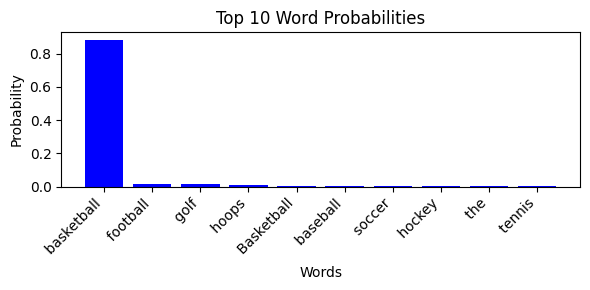

[(' basketball', 0.9309781789779663), (' golf', 0.030908379703760147), (' baseball', 0.009610244072973728), (' football', 0.007173153106123209), (' hoops', 0.004447477869689465), (' tennis', 0.0042616091668605804), (' soccer', 0.0013974071480333805), (' hockey', 0.0006243633106350899), (' Basketball', 0.00046644004760310054), (' horse', 0.00044291222002357244)]


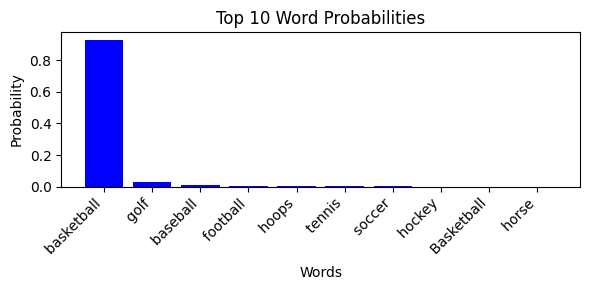

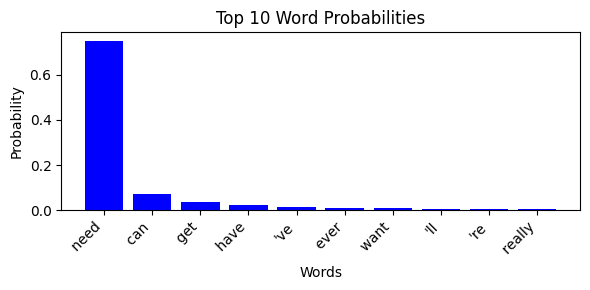

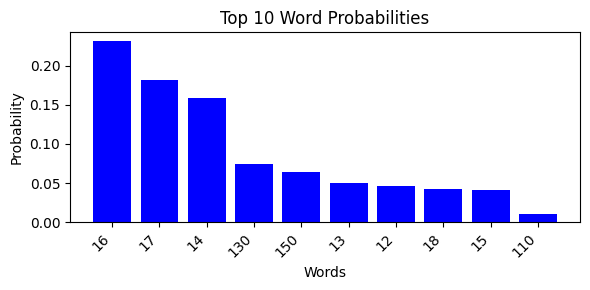

In [23]:
result = predict_probs_from_prompt(model, tokenizer, "Michael Jordan plays the sport of")  # basketball
print(result)
plot_word_probabilities(result)
result = predict_probs_from_prompt(model, tokenizer, "David Beckham plays the sport of soccer. Michael Jordan plays the sport of")  # basketball
print(result)
plot_word_probabilities(result)
result = predict_probs_from_prompt(model, tokenizer, "The first prominent paper on transformers and attention was 'Attention is all you") # need
plot_word_probabilities(result)
result = predict_probs_from_prompt(model, tokenizer, "The url to 'Attention is all you need' paper is http://https://arxiv.org/abs/") # 1706.03762
plot_word_probabilities(result)

In [24]:
## Measure the factual accuracy on a dataset
# Using ROME's facts dataset
import os, re, json
!ls /content/home
from util.globals import DATA_DIR
from dsets import KnownsDataset
knowns = KnownsDataset(DATA_DIR)

baselines     dsets	   globals.yml	LICENSE    README.md  scripts
CITATION.cff  experiments  hparams	notebooks  rome       util
data/known_1000.json does not exist. Downloading from https://rome.baulab.info/data/dsets/known_1000.json


100%|██████████| 335k/335k [00:00<00:00, 477kB/s]


Loaded dataset with 1209 elements


## Debug mode

In [25]:
print("MODEL_NAME = ", MODEL_NAME, " NUM_BEAMS = ", NUM_BEAMS, " CONTEXT = ", CONTEXT)
print("=======================================")

accuracy = avg_prediction_accuracy(model, tokenizer, knowns, debug=True)
print(f"Avg Accuracy: {accuracy * 100:.2f}%")
print("=======================================")

weighted_accuracy = weighted_prediction_accuracy(model, tokenizer, knowns, debug=True)
print(f"Weighted Accuracy: {weighted_accuracy * 100:.2f}%")
print("=======================================")

bleu_score = avg_bleu_score(model, tokenizer, knowns, debug=True)
print(f"Bleu score: {bleu_score:.4f}")
print("=======================================")

perplexity = avg_perplexity(model, tokenizer, knowns, debug=True)
print(f"Perplexity: {perplexity:.4f}")
print("=======================================")

h_perplexity = hf_perplexity(model, tokenizer, knowns, debug=True)
print(f"HF Perplexity: {h_perplexity:.4f}")
print("=======================================")

MODEL_NAME =  gpt2-medium  NUM_BEAMS =  3  CONTEXT =  Answer as a precise fact. 
Prompt:  Answer as a precise fact. Vinson Massif is located in the continent of expected prediction:  of actual prediction:   Antarctica
Prompt:  Answer as a precise fact. Beats Music is owned by expected prediction:  Apple, actual prediction:   Sony
Prompt:  Answer as a precise fact. Audible.com is owned by expected prediction:  Amazon.com, actual prediction:   Google
Prompt:  Answer as a precise fact. The Big Bang Theory premieres on expected prediction:  CBS actual prediction:   CBS
Prompt:  Answer as a precise fact. MacApp, a product created by expected prediction:  Apple actual prediction:   Apple
Avg Accuracy: 40.00%
Prompt:  Answer as a precise fact. Vinson Massif is located in the continent of expected prediction:  of
Prompt:  Answer as a precise fact. Beats Music is owned by expected prediction:  Apple,
Prompt:  Answer as a precise fact. Audible.com is owned by expected prediction:  Amazon.com,
Pr

  0%|          | 0/1 [00:00<?, ?it/s]

HF Perplexity: 46.5262


## Full Set metrics

In [26]:
# Accuracy: Measures the percentage of times the model correctly predicts the next token.
print("MODEL_NAME = ", MODEL_NAME, " NUM_BEAMS = ", NUM_BEAMS, " CONTEXT = ", CONTEXT)

accuracy = avg_prediction_accuracy(model, tokenizer, knowns)
print(f"Avg Factual Accuracy: {accuracy * 100:.2f}%")

weighted_accuracy = weighted_prediction_accuracy(model, tokenizer, knowns)
print(f"Weighted Factual Accuracy: {weighted_accuracy * 100:.2f}%")

# BLEU Score: n-gram precision and helps evaluate fluency and overlap between predicted and actual tokens.
bleu = avg_bleu_score(model, tokenizer, knowns)
print(f"Average Bleu score: {bleu:.4f}")

# Cross-Entropy Loss: the difference between the true distribution and the predicted distribution of the next token.
# Perplexity: exponential of cross entropy loss. Lower is better.
perplexity = avg_perplexity(model, tokenizer, knowns)
print(f"Avg Perplexity: {perplexity:.4f}")

h_perplexity = hf_perplexity(model, tokenizer, knowns)
print(f"HF Perplexity: {h_perplexity:.4f}")


MODEL_NAME =  gpt2-medium  NUM_BEAMS =  3  CONTEXT =  Answer as a precise fact. 
Avg Factual Accuracy: 11.66%
Weighted Factual Accuracy: 17.33%


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
NUM_BEAMS = 3
# BLEU Score: n-gram precision and helps evaluate fluency and overlap between predicted and actual tokens.
bleu = avg_bleu_score(model, tokenizer, knowns)
print(f"Average Bleu score: {bleu:.4f}")
